# 3D Single-shot Object Detection Method (Wheals) - 2D Transformations
---------------------------------------
#### Realizado por: Juan C. Peña y Eberto Benjumea

## Resumen
-----------
Este trabajo se enfoca en la selección de parámetros para el procesamiento y detección de **pápulas** en imágenes 3D mediante técnicas de *Self-supervised Deep Learning*.

La configuración recomendada es:




# Módulos y funciones necesarias
-------


In [1]:
#@title Libreria DeepTrack
%%capture
!pip install deeptrack

In [2]:
#@title Otras librerias y funciones utilizadas
%%capture
import os
import cv2
import scipy
import random
import numpy as np
import deeptrack as dt
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from scipy.spatial.transform import Rotation as R
from tensorflow.python.keras.callbacks import ModelCheckpoint, EarlyStopping, LearningRateScheduler

In [3]:
#@title Conexion con Google Drive
%%capture
from google.colab import drive
drive.mount('/content/drive')

In [73]:
#@title Funciones propias
#--------------------------------------------------------------------------------
#                       PREPROCESAMIENTO DEL RECORTE
#--------------------------------------------------------------------------------
# Normalización de imágenes
def normalize_images(data):
    if isinstance(data, np.ndarray):
        data = [data]

    normalized_images = []
    for image in data:
        image = np.nan_to_num(image)
        normalized_image = (image - np.quantile(image, 0.01)) / (np.quantile(image, 0.99) - np.quantile(image, 0.01))
        normalized_images.append(normalized_image)

    if len(normalized_images) == 1:
        return normalized_images[0]
    else:
        return normalized_images
#--------------------------------------------------------------------------------
# Visualizacion de histogramas
def visualize_histograms(original_image, transformed_image):
    fig, ax = plt.subplots(2, 2, figsize=(10, 5))

    ax[0, 0].imshow(original_image)
    ax[0, 0].set_title("Original Image")

    ax[0, 1].hist(original_image.ravel(), bins=256, color='blue', alpha=0.7)
    ax[0, 1].set_title("Original Image Histogram")

    ax[1, 0].imshow(transformed_image, vmin=0.0, vmax=1.0)
    ax[1, 0].set_title("Preprocessed Crop")

    ax[1, 1].hist(transformed_image.ravel(), bins=256, color='red', alpha=0.7)
    ax[1, 1].set_title("Preprocessed Image Histogram")

    plt.tight_layout()
    plt.show()
#--------------------------------------------------------------------------------
#Preprocesamiento del recorte
def preprocess_crop(crop, x, y, crop_size, plot=True):
    # Recorte del crop original
    crop = crop[y: y + crop_size, x: x + crop_size]
    # Copia de los datos originales para visualización posterior
    previous_crop = np.copy(crop)
    # Preprocesamiento del crop
    crop = normalize_images(crop)

    # Visualización
    if plot:
        visualize_histograms(previous_crop, crop)

    return crop
#--------------------------------------------------------------------------------
#                  GENERACION DE RECORTES TRANSFORMADOS EN 2D
#--------------------------------------------------------------------------------
# Generacion de recortes transformados
def generate_transformed_crops(Sp_coordinates, crop, transformation_ranges, num_images, crop_coords):
    # Extraer las coordenadas
    Spx, Spy, Spz = Sp_coordinates['Spx'], Sp_coordinates['Spy'], Sp_coordinates['Spz']

    # Extraer las coordenadas de recorte
    x, y, crop_size = crop_coords['x'], crop_coords['y'], crop_coords['crop_size']

    # Crear una matriz 4D para las coordenadas X, Y, Z y una matriz de unos del mismo tamaño
    coordinates = np.stack([Spx, Spy, Spz, np.ones_like(Spz)])

    # Crear una lista para almacenar los crops transformados
    transformed_crops = []

    # Agregar el crop original a la lista de crops transformados
    original_crop = crop
    transformed_crops.append(original_crop)

    # Iterar sobre la cantidad de imágenes a generar (restando 1 para el recorte original)
    for _ in range(num_images - 1):
        # Generar las transformaciones aleatorias dentro de los rangos especificados
        ax = np.random.uniform(*transformation_ranges['ax'])
        ay = np.random.uniform(*transformation_ranges['ay'])
        az = np.random.uniform(*transformation_ranges['az'])
        tx = np.random.uniform(*transformation_ranges['tx'])
        ty = np.random.uniform(*transformation_ranges['ty'])
        tz = np.random.uniform(*transformation_ranges['tz'])

        # Crear la matriz de rotación utilizando scipy
        r = R.from_euler('xyz', [ax, ay, az], degrees=True)
        Rrec = r.as_matrix()

        # Crear la matriz de transformación
        Mext_rec = np.eye(4)
        Mext_rec[:3, :3] = Rrec

        # Transformar los puntos utilizando la matriz de transformación
        transformed_coordinates = Mext_rec @ coordinates.reshape(4, -1)

        # Remodelar los puntos transformados de vuelta a la forma original
        transformed_coordinates = transformed_coordinates.reshape(4, Spz.shape[0], Spz.shape[1])

        # Crear la nueva imagen 2.5D con los valores de Z transformados
        new_image_2_5D = transformed_coordinates[2, :, :]

        # Realizar la traslación en X e Y en la imagen 2.5D
        translated_image_2_5D = np.roll(new_image_2_5D, (int(tx), int(ty)), axis=(1, 0))

        # Realizar la rotación en Z y la traslación en Z en la imagen 2.5D
        rows, cols = translated_image_2_5D.shape
        M = cv2.getRotationMatrix2D((cols/2, rows/2), az, 1)
        dst = cv2.warpAffine(translated_image_2_5D, M, (cols, rows))
        transformed_image = dst + tz

        # Obtener el crop de la imagen transformada
        transformed_crop = transformed_image[y : y+crop_size, x : x+crop_size]

        # Agregar el crop transformado a la lista de crops transformados
        transformed_crops.append(transformed_crop)

    return transformed_crops
#--------------------------------------------------------------------------------
# Grafica de recortes transformados
def plot_transformed_crops(transformed_crops, num_cols=10, figsize=(12, 6)):
    num_images = len(transformed_crops)
    num_rows = int(np.ceil(num_images / num_cols))

    fig, axes = plt.subplots(num_rows, num_cols, figsize=figsize)

    for i, ax in enumerate(axes.flatten()):
        if i < num_images:
            ax.imshow(transformed_crops[i])
            ax.axis('off')
        else:
            ax.axis('off')

    plt.tight_layout()
    plt.show()
#--------------------------------------------------------------------------------
#                     APLICACION DE TRANSFORMACIONES 2D
#--------------------------------------------------------------------------------
# Generacion de transformaciones 2D
def apply_2d_transformations(transformed_crops, transformations):
  pipeline = None
  for transformation in transformations:
    if pipeline is None:
      pipeline = transformation
    else:
      pipeline = pipeline >> transformation

  training_images = [np.expand_dims(image, axis=-1) for image in transformed_crops]
  train_set = dt.Value(lambda: np.array(random.choice(training_images))) >> pipeline

  return train_set
#--------------------------------------------------------------------------------
#                       ENTRANAMIENTO DEL MODELO
#--------------------------------------------------------------------------------
# Configuracion y entrenamiento del modelo
def train_model(model, train_set, weights_path, train_mode=True, epochs=40):

  callbacks = [ModelCheckpoint(filepath=weights_path,
                               save_weights_only=True,
                               monitor='total_loss',
                               mode='min',
                               save_best_only=True),

               EarlyStopping(monitor="total_loss",
                             patience=15,
                             verbose=1,
                             mode="auto",
                             restore_best_weights=True),

               LearningRateScheduler(lambda epoch, lr: lr if epoch < 10 else lr * np.exp(-0.1))]

  if train_mode:
      history = model.fit(
          train_set,
          epochs=epochs,
          batch_size=8,
          callbacks=callbacks
      )

      fig, ax = plt.subplots(1, 2, figsize=(10, 4))

      # Plot total_loss
      ax[0].plot(history.history['total_loss'], label='Total Loss')
      ax[0].set_title('Total Loss over time')
      ax[0].set_xlabel('Epochs')
      ax[0].set_ylabel('Loss')
      ax[0].legend()

      # Plot consistency_loss
      ax[1].plot(history.history['consistency_loss'], label='Consistency Loss')
      ax[1].set_title('Consistency Loss over time')
      ax[1].set_xlabel('Epochs')
      ax[1].set_ylabel('Loss')
      ax[1].legend()

      plt.show()

  else:
      model.load_weights(weights_path)

  return model
#--------------------------------------------------------------------------------
#                    DETECCION MULTI-ESCALA DE OBJETOS
#--------------------------------------------------------------------------------
# Carga de datos de prueba
def load_test_data(file_path, key='Spz'):
    test_data = scipy.io.loadmat(file_path)
    test_image = test_data[key]
    return test_image
#--------------------------------------------------------------------------------
# Preprocesamiento de los datos de prueba
def preprocess_test_image(test_image):
    previous_test_image = np.copy(test_image)
    test_image = normalize_images(test_image)
    visualize_histograms(previous_test_image, test_image)

    return test_image, previous_test_image
#--------------------------------------------------------------------------------
# Escalamiento de imagenes
def scale_test_images(test_image, scales, plot=True):
    x_shape = test_image.shape[0]
    y_shape = test_image.shape[1]
    scaled_images = [cv2.resize(test_image, (int(y_shape // scale), int(x_shape // scale))) for scale in scales]

    if plot:
        fig, ax = plt.subplots(1, len(scaled_images), figsize=(10, 4))
        fig.tight_layout()
        fig.suptitle('Scaled 3D images', y=1)
        for index in range(len(scaled_images)):
            ax[index].imshow(scaled_images[index], vmin=0.0, vmax=1.0)

    return scaled_images
#--------------------------------------------------------------------------------
# Deteccion de objetos
def detect_objects(scaled_images, model, downsample, cutoff=0.9):
    alpha = 1 - cutoff
    mode = "quantile"
    all_detections = []

    for index in range(len(scaled_images)):
        test_set = scaled_images[index][np.newaxis, :, :, np.newaxis]
        test_set = test_set[:, ::downsample, ::downsample, :]
        detections = model.predict_and_detect(test_set, alpha=alpha, beta=1-alpha, cutoff=cutoff, mode=mode)[0]
        detections[:, 0] = detections[:, 0] * downsample
        detections[:, 1] = detections[:, 1] * downsample
        all_detections.append(detections)

    return all_detections
#--------------------------------------------------------------------------------
# Visualizacion de detecciones
def visualize_detections(scaled_images, all_detections):
    fig, ax = plt.subplots(1, len(scaled_images), figsize=(25, 5))
    fig.tight_layout()
    fig.suptitle('Detections', y=1)
    colors = 'rgb'

    for index in range(len(scaled_images)):
        ax[index].imshow(scaled_images[index], vmin=0.0, vmax=1.0)
        ax[index].scatter(all_detections[index][:, 1], all_detections[index][:, 0], color=colors[index])

    plt.show()
#--------------------------------------------------------------------------------
# Creacion de bounding boxes
def calculate_bounding_boxes(scaled_images, all_detections, crop_size):
    final_image = scaled_images[0]
    original_box_size = crop_size
    all_bboxes = []

    original_height, original_width = final_image.shape[:2]

    for index in range(len(all_detections)):
        current_height, current_width = scaled_images[index].shape[:2]

        box_size = original_box_size * (current_height / original_height)
        half_size = box_size / 2.0

        bboxes = np.zeros((len(all_detections[index]), 4))

        for i, point in enumerate(all_detections[index]):
            bboxes[i, 0] = point[0] - half_size
            bboxes[i, 1] = point[1] - half_size
            bboxes[i, 2] = point[0] + half_size
            bboxes[i, 3] = point[1] + half_size

        all_bboxes.append(bboxes)

    return all_bboxes
#--------------------------------------------------------------------------------
# Visualizacion de bounding boxes
def visualize_bounding_boxes(scaled_images, all_bboxes):
    fig, axs = plt.subplots(1, len(scaled_images), figsize=(25, 5))
    fig.tight_layout()
    fig.suptitle('Bounding boxes', y=1)
    colors = ['r', 'g', 'b']  # red, green, blue

    for i, image in enumerate(scaled_images):
        axs[i].imshow(image, vmin=0.0, vmax=1.0)

        for bbox in all_bboxes[i]:
            rect = plt.Rectangle((bbox[1], bbox[0]), bbox[3] - bbox[1], bbox[2] - bbox[0],
                                 linewidth=2, edgecolor=colors[i], facecolor='none')
            axs[i].add_patch(rect)

    plt.show()
#--------------------------------------------------------------------------------
#                       SUPRESION DEL NO MAXIMO
#--------------------------------------------------------------------------------
# Ajuste de bounding boxes
def adjust_bounding_boxes(all_bboxes, scales):
    all_bboxes_scaled = []
    for i in range(len(scales)):
        bboxes_scaled = all_bboxes[i] * scales[i]
        all_bboxes_scaled.append(bboxes_scaled)
    return all_bboxes_scaled
#--------------------------------------------------------------------------------
# Aplicacion de Supresion del No Maximo
def apply_nms(all_bboxes_scaled, threshold=0.6):
    all_bboxes_concat = np.concatenate(all_bboxes_scaled)
    confidences = [1] * len(all_bboxes_concat)
    indices = cv2.dnn.NMSBoxes(all_bboxes_concat.tolist(), confidences, score_threshold=0, nms_threshold=threshold)
    indices = [int(i) for i in indices]
    final_bboxes = [all_bboxes_concat[i] for i in indices]
    return final_bboxes
#--------------------------------------------------------------------------------
# Visualizacion de bounding boxes finales
def visualize_final_bboxes(final_image, final_bboxes):
    fig, ax = plt.subplots(1, figsize=(8, 5))
    ax.imshow(final_image, vmin=0.0, vmax=1.0)
    for bbox in final_bboxes:
        rect = patches.Rectangle((bbox[1], bbox[0]), bbox[3] - bbox[1], bbox[2] - bbox[0], linewidth=1, edgecolor='r', facecolor='none')
        ax.add_patch(rect)
    plt.show()
    return final_image
#--------------------------------------------------------------------------------

-----------

# Metodología para la detección de objetos 3D
-----------

In [6]:
#@title Carga de informacion
#@markdown ---
train_image_path = '/content/drive/MyDrive/Investigacion/Data/MATLAB/database/maniqui/nosurf/r3d_00.mat' #@param {type:"string"}
train_data = scipy.io.loadmat(train_image_path)

Xkey = 'Xdata'#@param{types:"string"}
Ykey = 'Ydata'#@param{types:"string"}
Zkey = 'Zdata'#@param{types:"string"}

keys = {'x': Xkey, 'y': Ykey, 'z': Zkey}
Spx, Spy, Spz = train_data[keys['x']], train_data[keys['y']], train_data[keys['z']]
#@markdown ---

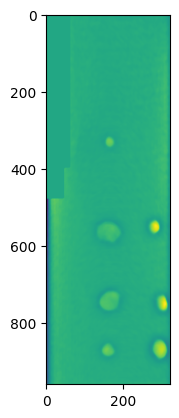

In [7]:
#@title Visualizacion de la imagen original
plt.imshow(Spz)

## 1. Preprocesamiento del recorte
----


In [45]:
#@title Seleccion del crop
#@markdown ---
x = 125 #@param {type:"integer"}
y = 290 #@param {type:"integer"}
crop_size = 80 #@param {type:"integer"}
#@markdown ---

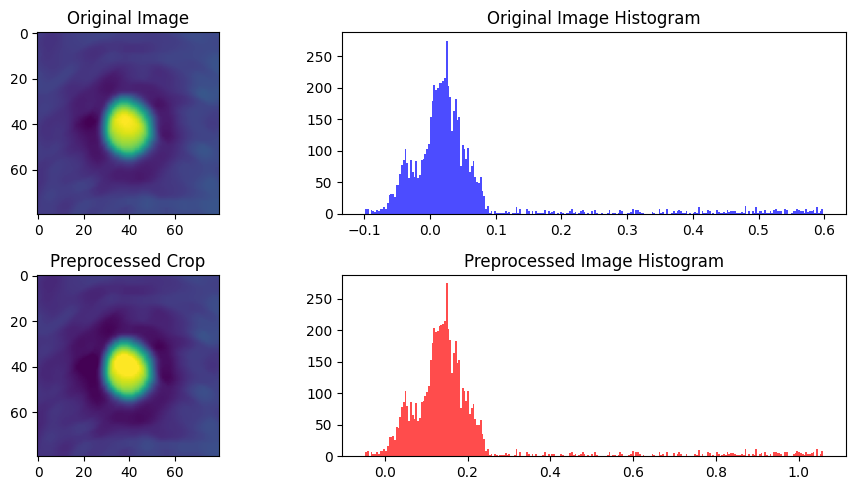

In [46]:
#@title Visualización del recorte original y preprocesado con sus histogramas
preprocessed_crop = preprocess_crop(Spz, x, y, crop_size, plot=True)

## 2. Aplicación de Transformaciones 2D
-----




In [47]:
#@title Tamaño imagen de entrenamiento [IMPORTANTE]
#@markdown ---
wide = 40 #@param {type:"integer"}
downsample = crop_size // wide
#@markdown ---

In [48]:
#@title Conjunto de transformaciones [IMPORTANTE]
#@markdown ---
min_scale = 0.8 #@param {type:"slider", min:0, max:2, step:0.1}
max_scale = 2 #@param {type:"slider", min:0, max:2, step:0.1}
translation = 1.5 #@param {type:"slider", min:0, max:2, step:0.1}
rotation = 2 #@param {type:"slider", min:0, max:2, step:0.1}
add = 0.1 #@param {type:"slider", min:0, max:2, step:0.1}
gaussian_min = 0 #@param {type:"slider", min:0, max:0.1, step:0.01}
gaussian_max = 0.01 #@param {type:"slider", min:0, max:0.1, step:0.01}
multiply_min = 0.6 #@param {type:"slider", min:0, max:2, step:0.1}
multiply_max = 1.2 #@param {type:"slider", min:0, max:2, step:0.1}
#@markdown ---

transformations = (dt.Affine(scale=lambda:np.random.uniform(min_scale, max_scale, 2), translate=lambda:np.random.uniform(-translation, translation, 2), rotate=lambda: np.random.rand()*np.pi*rotation),
                   dt.AveragePooling(ksize=(downsample, downsample, 1)),
                   dt.Add(lambda: np.random.randn() * add),
                   dt.Gaussian(sigma=lambda:np.random.uniform(gaussian_min, gaussian_max)),
                   dt.Multiply(lambda: np.random.uniform(multiply_min, multiply_max)))

<Axes: >

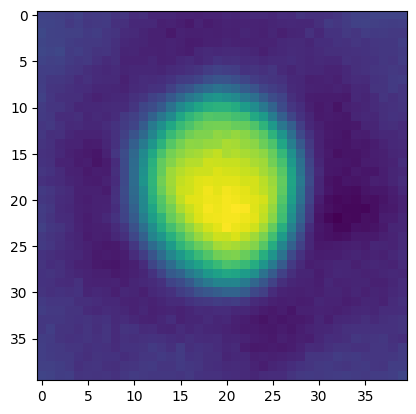

In [49]:
#@title Generacion de ejemplos con transformaciones 2D
train_set = apply_2d_transformations([preprocessed_crop], transformations)
train_set.plot()

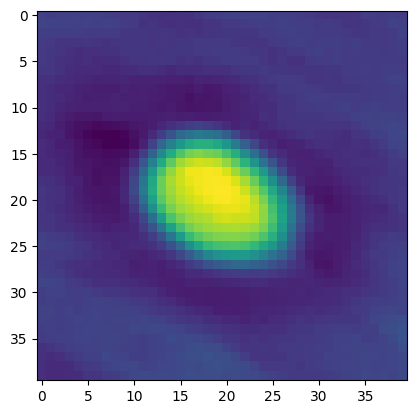

In [50]:
#@title Visualizacion de mas ejemplos
transformed_image = train_set.update()()
plt.imshow(transformed_image)

## 3. Entrenamiento del Modelo
-------------



In [51]:
#@title Entrenamiento
#@markdown ---
model = dt.models.LodeSTAR(input_shape=(None, None, 1))
TRAIN_MODE = True #@param {type:"boolean"}
weights_path = '/content/drive/MyDrive/Investigacion/Model/checkpoints/nosurf-wheals-2D' #@param {type:"string"}
epochs = 40 #@param {type:"integer"}
#@markdown ---

Generating 163 / 160 samples before starting training
Epoch 1/40
164/164 [==============================] - 17s 16ms/step - total_loss: 1.4214 - consistency_loss: 0.7115 - lr: 0.0010
Epoch 2/40
164/164 [==============================] - 5s 32ms/step - total_loss: 0.6843 - consistency_loss: 0.3240 - lr: 0.0010      
Epoch 3/40
164/164 [==============================] - 8s 51ms/step - total_loss: 0.3672 - consistency_loss: 0.1613 - lr: 0.0010            
Epoch 4/40
164/164 [==============================] - 6s 36ms/step - total_loss: 0.3315 - consistency_loss: 0.1620 - lr: 0.0010                 
Epoch 5/40
164/164 [==============================] - 5s 33ms/step - total_loss: 0.2908 - consistency_loss: 0.1323 - lr: 0.0010                       
Epoch 6/40
164/164 [==============================] - 7s 41ms/step - total_loss: 0.2676 - consistency_loss: 0.1169 - lr: 0.0010                         
Epoch 7/40
164/164 [==============================] - 9s 54ms/step - total_loss: 0.2271 - cons

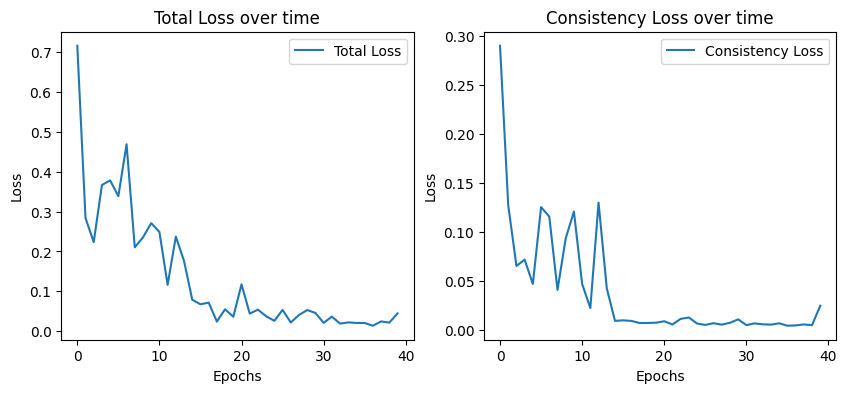

In [52]:
#@title Entrenamiento del modelo o carga de pesos (depende de TRAIN_MODE)
model = train_model(model, train_set, weights_path, train_mode=TRAIN_MODE, epochs=epochs)

## 4. Detección multi-escala de objetos
------


In [53]:
#@title Deteccion multi-escala
#@markdown ---
test_path = '/content/drive/MyDrive/Investigacion/Data/MATLAB/database/maniqui/nosurf/r3d_01.mat' #@param {type:"string"}
key = 'Zdata' #@param {type:"string"}
test_image = load_test_data(test_path, key=key)
#@markdown ---

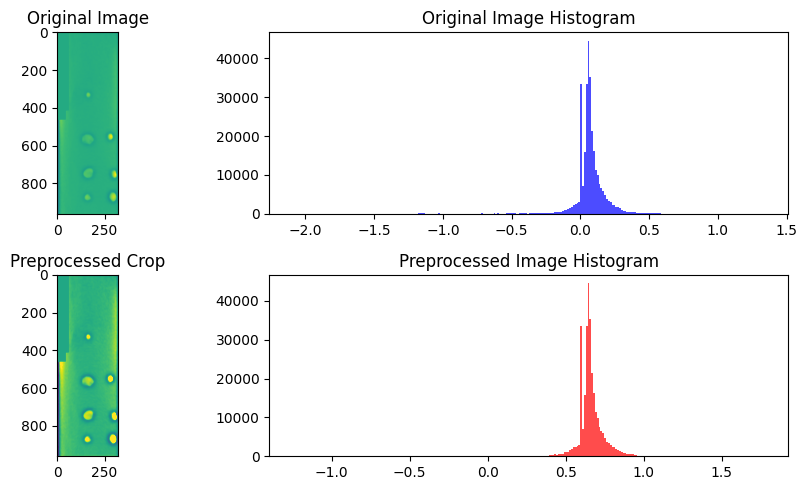

In [54]:
#@title Visualizacion de la imagen de prueba antes y despues de preprocesar
preprocessed_image, previous_image = preprocess_test_image(test_image)

In [68]:
#@title Escalas y umbral de deteccion [IMPORTANTE]
#@markdown ---
first_scale = 1 #@param {type:"number"}
second_scale = 1.5 #@param {type:"number"}
third_scale = 2 #@param {type:"number"}
scales = [first_scale, second_scale, third_scale]
cutoff = 0.995 #@param {type:"number"}
#@markdown ---

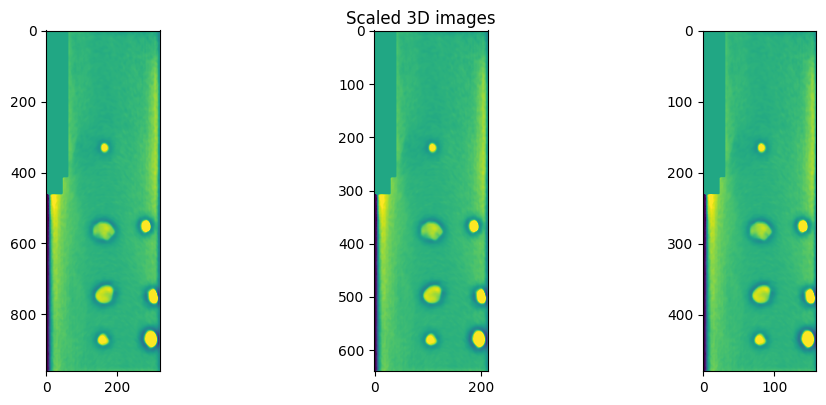

In [69]:
#@title Escalamiento de las imagenes de prueba
scaled_images = scale_test_images(preprocessed_image, scales)

1/1 [==============================] - 0s 22ms/step


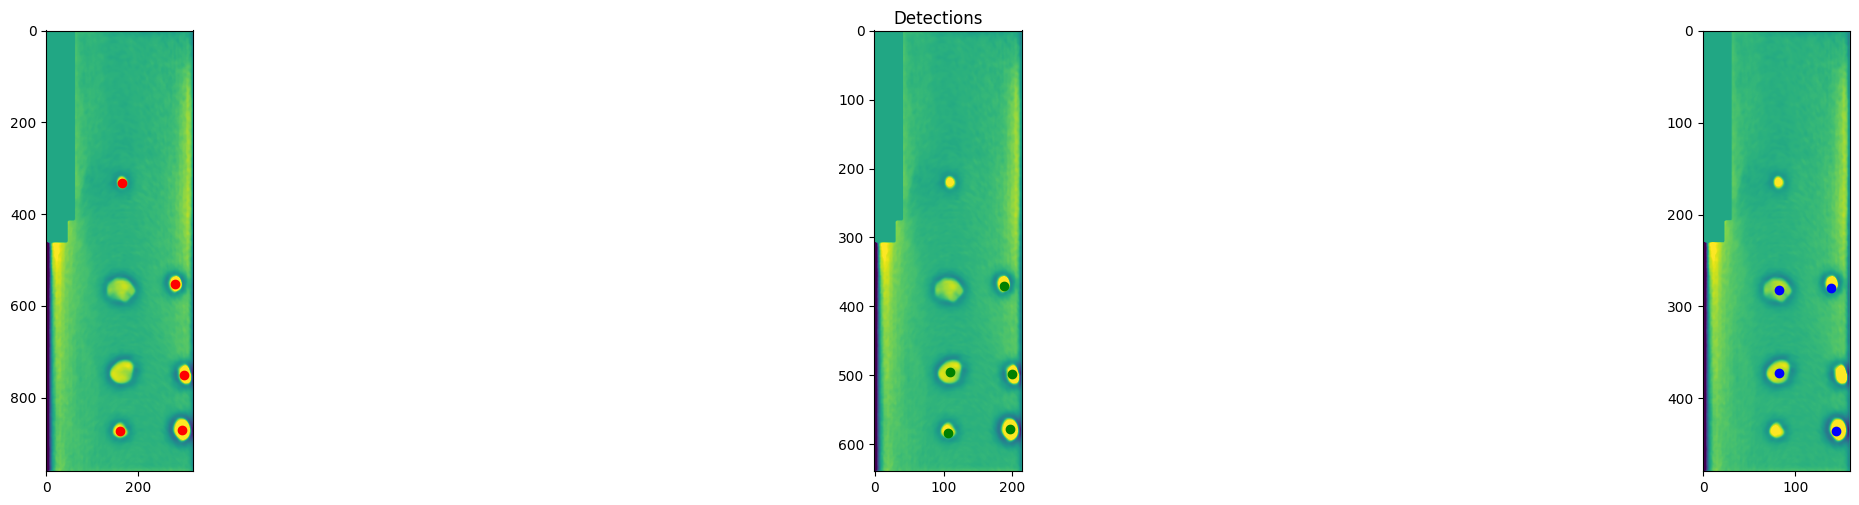

In [70]:
#@title Deteccion de objetos en cada escala
all_detections = detect_objects(scaled_images, model, cutoff=cutoff, downsample=downsample)
visualize_detections(scaled_images, all_detections)

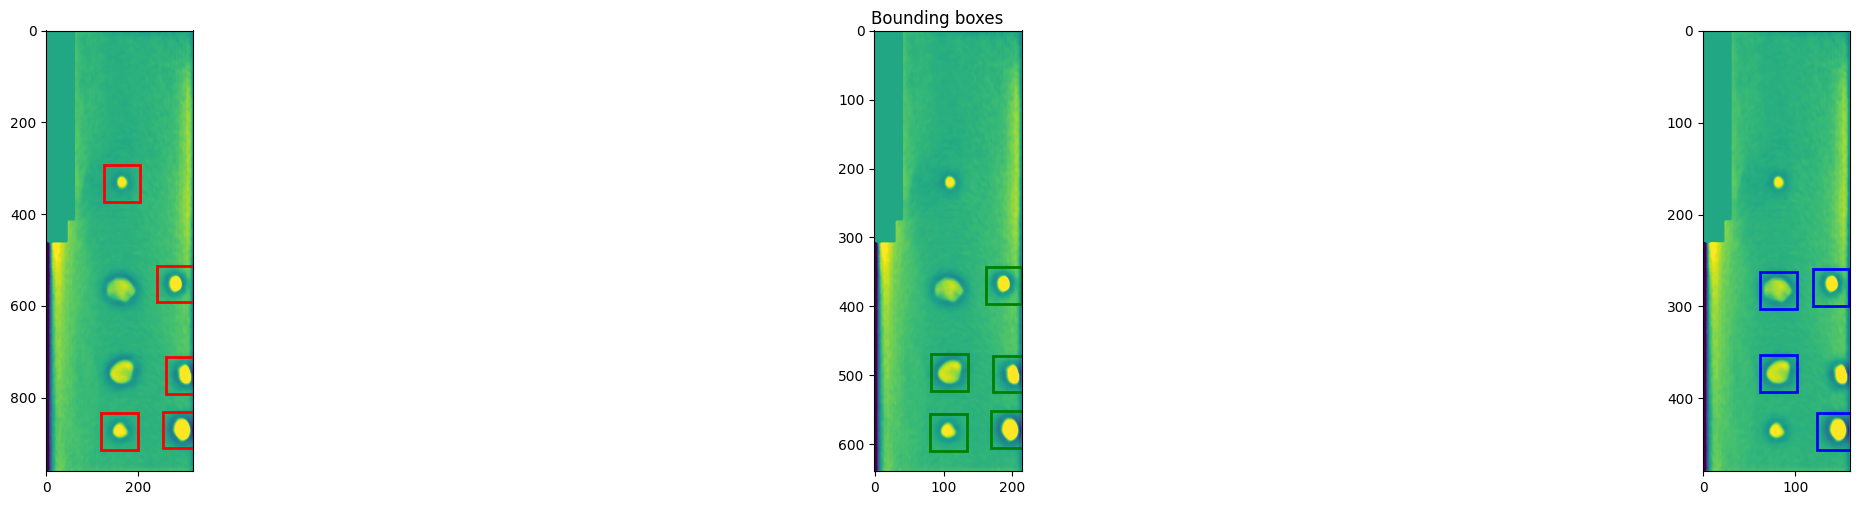

In [71]:
#@title Creacion de bounding boxes en cada escala
all_bboxes = calculate_bounding_boxes(scaled_images, all_detections, crop_size)
visualize_bounding_boxes(scaled_images, all_bboxes)

## 5. Supresión del No Máximo
-----


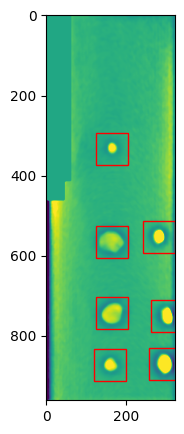

In [75]:
#@title Aplicacion de la supresion del no maximo
all_bboxes_scaled = adjust_bounding_boxes(all_bboxes, scales)
final_bboxes = apply_nms(all_bboxes_scaled, threshold=0.7)
final_image = visualize_final_bboxes(scaled_images[0], final_bboxes)

### Imagen 3
---

In [86]:
print(arm.shape)
print(image2.shape)
print(image3.shape)

(961, 270)
(961, 266)
(961, 266)


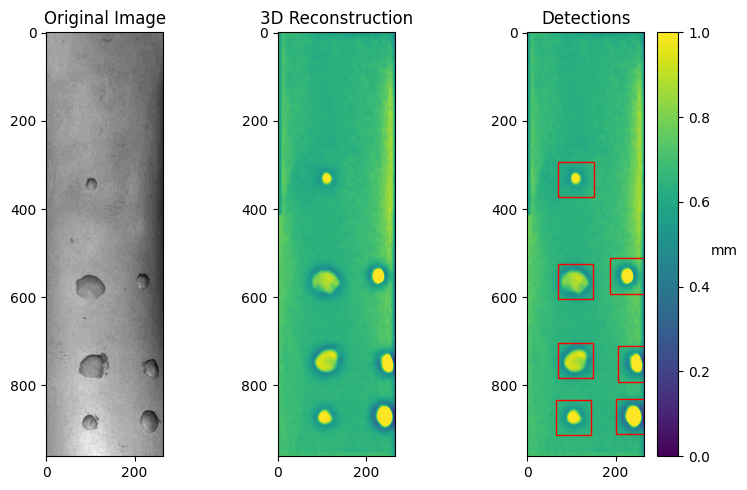

In [90]:
t = 55
arm = plt.imread('/content/drive/MyDrive/Investigacion/Data/MATLAB/database/maniqui/images/r3d_00.png')
arm = arm[:961, 830+t:1096+t]

fig, ax = plt.subplots(1, 3, figsize=(8, 5))

# Primer subplot: arm
im1 = ax[0].imshow(arm, cmap='gray')
ax[0].set_title('Original Image')

# Segundo subplot: preprocessed_image
#im2 = ax[1].imshow(preprocessed_image, vmin=0.0, vmax=1.0)
image2 = preprocessed_image[:,t:]
im2 = ax[1].imshow(image2, vmin=0.0, vmax=1.0)
ax[1].set_title('3D Reconstruction')

# Tercer subplot: final_image con bounding boxes y colorbar
image3 = final_image[:,t:]
im3 = ax[2].imshow(image3, vmin=0.0, vmax=1.0)
ax[2].set_title('Detections')
for bbox in final_bboxes:
    rect = patches.Rectangle((bbox[1]-t, bbox[0]), bbox[3] - bbox[1], bbox[2] - bbox[0], linewidth=1, edgecolor='r', facecolor='none')
    ax[2].add_patch(rect)

# Agregamos el colorbar a la tercera imagen
cbar = fig.colorbar(im2, ax=ax[2])
cbar.set_label('mm', rotation=0, labelpad=10)

plt.tight_layout()
plt.show()